# Example 6.2: Random walk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

**The MC update**
$$
    V(S_t) = V(S_t) + \alpha[\overbrace{G_t}^\text{MC target} - V(S_t)]
$$

**The TD update**
$$
    V(S_t) = V(S_t) + \alpha[\overbrace{R_{t+1} + \gamma V(S_{t+1})}^{\text{TD target}} - V(S_t)]
$$

## Markov reward process (MRP)
An MRP is a Markov decision process without actions —
we do not distinguish between dynamics of the enviroment and the dynamics based on actions.

In [3]:
n_states = 5 + 1 # total state plus terminal state
states = np.arange(n_states)
mrp = np.zeros((n_states, n_states))
mrp[0, 0] = 1.0

for i in range(1, n_states):
    iprev = i - 1
    inext = (i + 1) % n_states
    mrp[i, [i - 1, inext]] = 1/2

mrp

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5],
       [0.5, 0. , 0. , 0. , 0.5, 0. ]])

In [4]:
value_array = np.arange(1, n_states) / n_states

In [5]:
@njit
def set_seed(seed):
    return np.random.seed(seed)
    
@njit
def sample_run(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r += 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist[:-1])
    r_hist = np.array(r_hist)
    return s_hist, r_hist


@njit
def sample_run_full(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r += 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist)
    r_hist = np.array(r_hist)
    return s_hist, r_hist


@njit
def run_and_update_mc(value, s, alpha, gamma):
    # Every-visit MC
    value = value.copy()

    s_hist, rew_hist = sample_run(s)
    ret_tot = 0.0
    for (s, ret) in zip(s_hist[::-1], rew_hist[::-1]):
        ret_tot += ret
        value[s] = value[s] + alpha * (ret_tot - value[s])
    return value


@njit
def run_and_update_td(value, s, alpha, gamma):
    """
    Run a sample of the MRP and update the
    input value array.
    ----
    Parameters:
    s: float
        initial state
    value: np.array
        Current value estimate
    """
    value = value.copy()
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r += 1 if (s == n_states - 1) and (snext == 0) else 0

        target = r + gamma * value[snext]
        value[s] = value[s] + alpha * (target - value[s])
        s = snext
    return value


@njit
def run_and_update_sims(n_sims, value_init, sinit, alpha, gamma, run_update_fn):
    """
    Run and update the value function for n_sims number of iterations
    """
    n_states = len(value_init)
    value_hist = np.zeros((n_sims, n_states))
    rmse_hist = np.zeros(n_sims)

    # initial state
    value = value_init.copy()
    rmse = np.sqrt(np.power(value[1:] - value_array, 2).mean())
    value_hist[0] = value
    rmse_hist[0] = rmse
    
    for n in range(1, n_sims):
        value = run_update_fn(value, sinit, alpha, gamma)
        rmse = np.sqrt(np.power(value[1:] - value_array, 2).mean())
        value_hist[n] = value
        rmse_hist[n] = rmse
        
    return rmse_hist, value_hist


@njit
def multiple_run_and_update_sims(n_sims, n_steps, value_init, sinit, alpha, gamma, run_update_fn):
    sims_rmse_hist = np.zeros((n_sims, n_steps))
    values_final = np.zeros((n_sims, n_states))
    for n in range(n_sims):
        rmse_hist, value_hist = run_and_update_sims(n_steps, value_init, sinit, alpha, gamma, run_update_fn)
        sims_rmse_hist[n] = rmse_hist
        values_final[n] = value_hist[-1]
        
    return sims_rmse_hist, values_final

In [6]:
n_steps = 100
value_init = np.zeros(n_states) + 0.5
value_init[0] = 0.0
alpha = 0.1
gamma  = 1.0
sinit = 3

set_seed(3141)
rmse_hist, value_td = run_and_update_sims(n_steps, value_init, sinit, alpha, gamma, run_and_update_td)

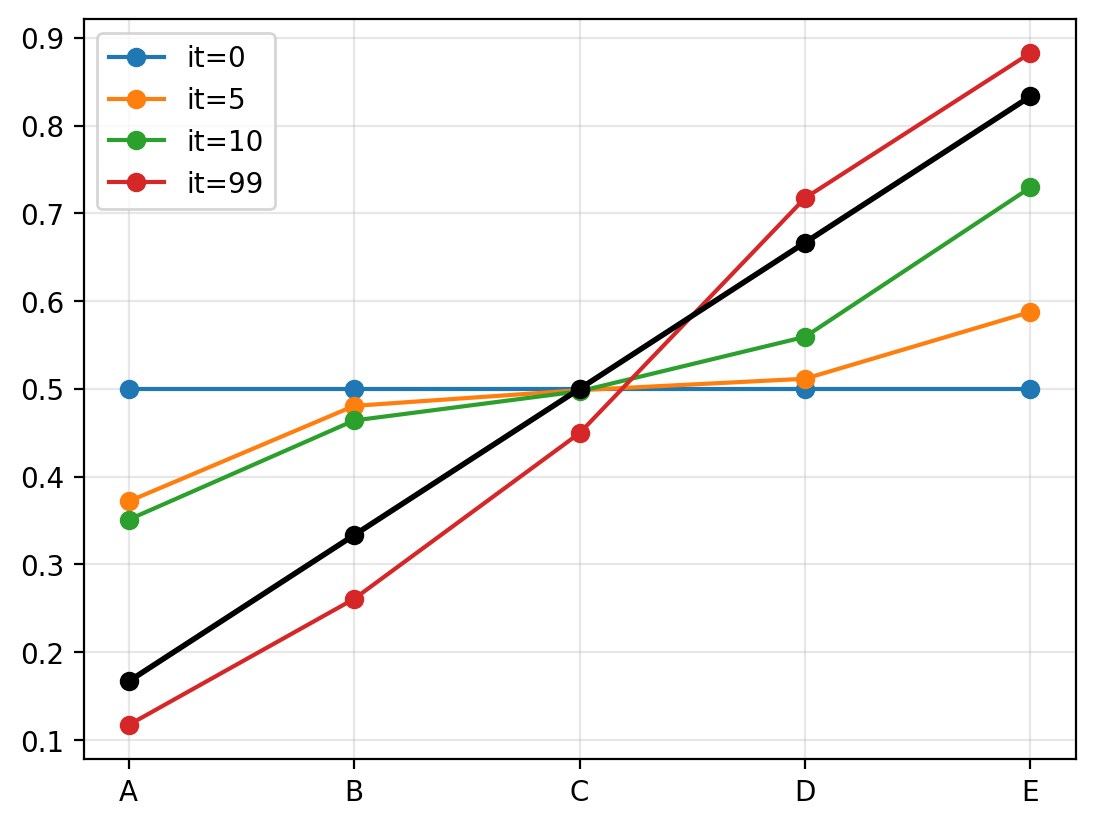

In [7]:
its = [0, 5, 10, 99]
for i in its:
    plt.plot(value_td[i, 1:], marker="o", label=f"it={i}")
plt.plot(value_array, marker="o", c="black", linewidth=2)
labels = "A B C D E".split()
plt.xticks(states[:-1], labels=labels)
plt.legend()
plt.grid(alpha=0.3);

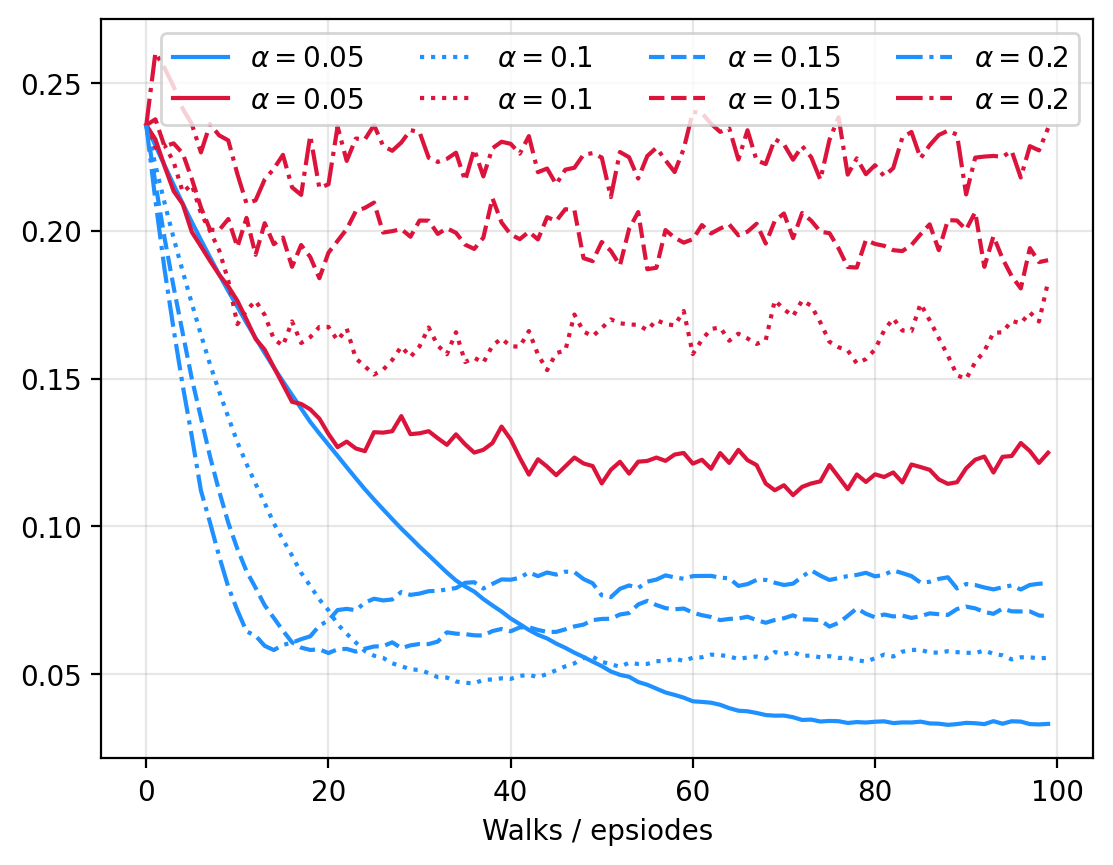

In [8]:
n_sims = 150
n_steps = 100

set_seed(314)
alpha_vals = [0.05, 0.1, 0.15, 0.2]
lstyles = ["solid", "dotted", "dashed", "dashdot"]
for alpha, ls in zip(alpha_vals, lstyles):
    sims_rmse_hist, _ = multiple_run_and_update_sims(n_sims, n_steps, value_init, sinit, alpha, gamma, run_and_update_td)
    label = r"$\alpha="f"{alpha}$"
    plt.plot(sims_rmse_hist.mean(axis=0), c="dodgerblue", linestyle=ls, label=label)

    sims_rmse_hist_mc, values_final = multiple_run_and_update_sims(n_sims, n_steps, value_init, sinit, alpha, gamma, run_and_update_mc)
    label = r"$\alpha="f"{alpha}$"
    plt.plot(sims_rmse_hist_mc.mean(axis=0), c="crimson", linestyle=ls, label=label)

plt.xlabel("Walks / epsiodes")
plt.legend(ncol=4)
plt.grid(alpha=0.3)

## Batch updating

In [625]:
@njit
def sample_run_full_multiple(state_init, n_runs):
    state_hist_full = np.array([])
    rewards_hist_full = np.array([])
    
    for n in range(n_runs):
        s_hist, r_hist = sample_run_full(state_init)

@njit
def run_and_batch_update_mc(value, sinit, alpha, gamma, state_hist, return_hist):
    # Every-visit (batch update) MC
    increments = np.zeros_like(value)

    s_hist_new, rew_hist = sample_run(sinit)
    ret_hist_new = rew_hist[::-1].cumsum()[::-1]
    
    # Increase state and return history
    state_hist = np.concatenate((state_hist, s_hist_new))
    return_hist = np.concatenate((return_hist, ret_hist_new))
    
    for (s, ret) in zip(state_hist, return_hist):
        increments[s] += alpha * (ret - value[s])

    value = value + increments
    return value, (state_hist, return_hist)


@njit
def run_and_batch_update_td(value, sinit, alpha, gamma, state_hist, reward_hist):
    # Every-visit (batch update) MC
    increments = np.zeros_like(value)

    s_hist_new, rew_hist_new = sample_run_full(sinit)
    # Increase state and return history
    state_hist = np.concatenate((state_hist, s_hist_new))
    reward_hist = np.concatenate((reward_hist, rew_hist_new, np.array([-1])))
    
    for (s, snext, r) in zip(state_hist[:-1], state_hist[1:], reward_hist):
        # don't update terminal state
        # if (s == 0) and (snext == sinit):
        if (r == -1) or (s == 0):
            continue
        target = r + gamma * value[snext]
        # value[s] = value[s] + alpha * (target - value[s])
        increments[s] += alpha * (target - value[s])

    value = value + increments
    return value, (state_hist, reward_hist)

In [626]:
def run_and_batch_update_sims(n_sims, value_init, sinit, alpha, gamma, run_update_fn):
    n_states = len(value_init)
    value_hist = np.zeros((n_sims, n_states))
    rmse_hist = np.zeros(n_sims)
    
    state_hist = np.array([], dtype=int)
    return_hist = np.array([])
    
    # initial state
    value = value_init.copy()
    rmse = np.sqrt(np.power(value[1:] - value_array, 2).mean())
    value_hist[0] = value
    rmse_hist[0] = rmse
    
    for n in range(n_sims):
        value, (state_hist, return_hist) = run_update_fn(
            value, sinit, alpha, gamma, state_hist, return_hist
        )
        rmse = np.sqrt(np.power(value[1:] - value_array, 2).mean())
        value_hist[n] = value
        rmse_hist[n] = rmse

    return rmse_hist, value_hist#, (state_hist, return_hist)


def multiple_run_and_batch_update_sims(n_sims, n_steps, value_init, sinit, alpha, gamma, run_update_fn):
    sims_rmse_hist = np.zeros((n_sims, n_steps))
    values_final = np.zeros((n_sims, n_states))
    for n in range(n_sims):
        rmse_hist, value_hist = run_and_batch_update_sims(n_steps, value_init, sinit, alpha, gamma, run_update_fn)
        sims_rmse_hist[n] = rmse_hist
        values_final[n] = value_hist[-1]
        
    return sims_rmse_hist, values_final

In [627]:
value_init = np.zeros(n_states) + 0.5
value_init[0] = 0.0
sinit = 3
gamma = 1.0

In [628]:
n_sims = 150
n_steps = 200

alpha = 1e-3
sims_rmse_mc_hist, values_mc_final = multiple_run_and_batch_update_sims(
    n_sims, n_steps, value_init, sinit, alpha, gamma, run_and_batch_update_mc
)

In [629]:
sims_rmse_td_hist, values_td_final = multiple_run_and_batch_update_sims(
    n_sims, n_steps, value_init, sinit, alpha, gamma, run_and_batch_update_td
)

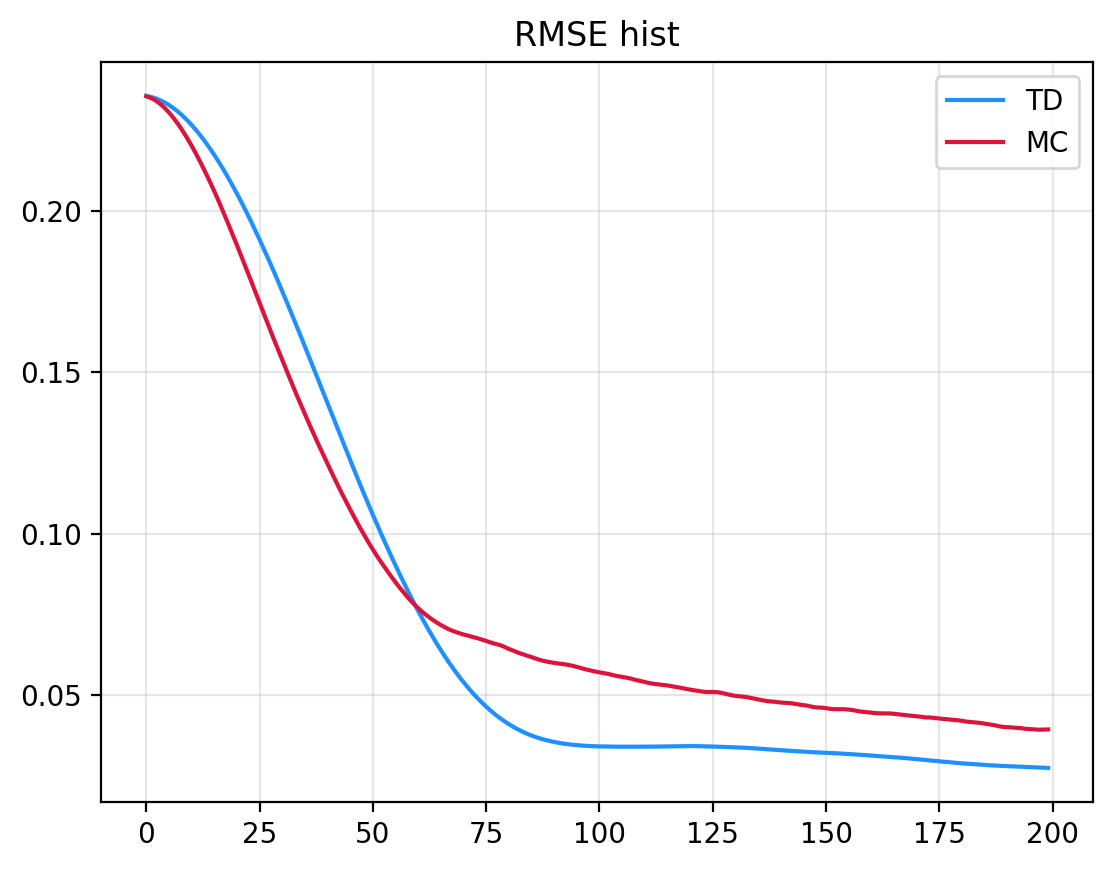

In [632]:
plt.plot(sims_rmse_td_hist.mean(axis=0), c="dodgerblue", label="TD")
plt.plot(sims_rmse_mc_hist.mean(axis=0), c="crimson", label="MC")
plt.legend()
plt.title("RMSE hist")
plt.grid(alpha=0.3)

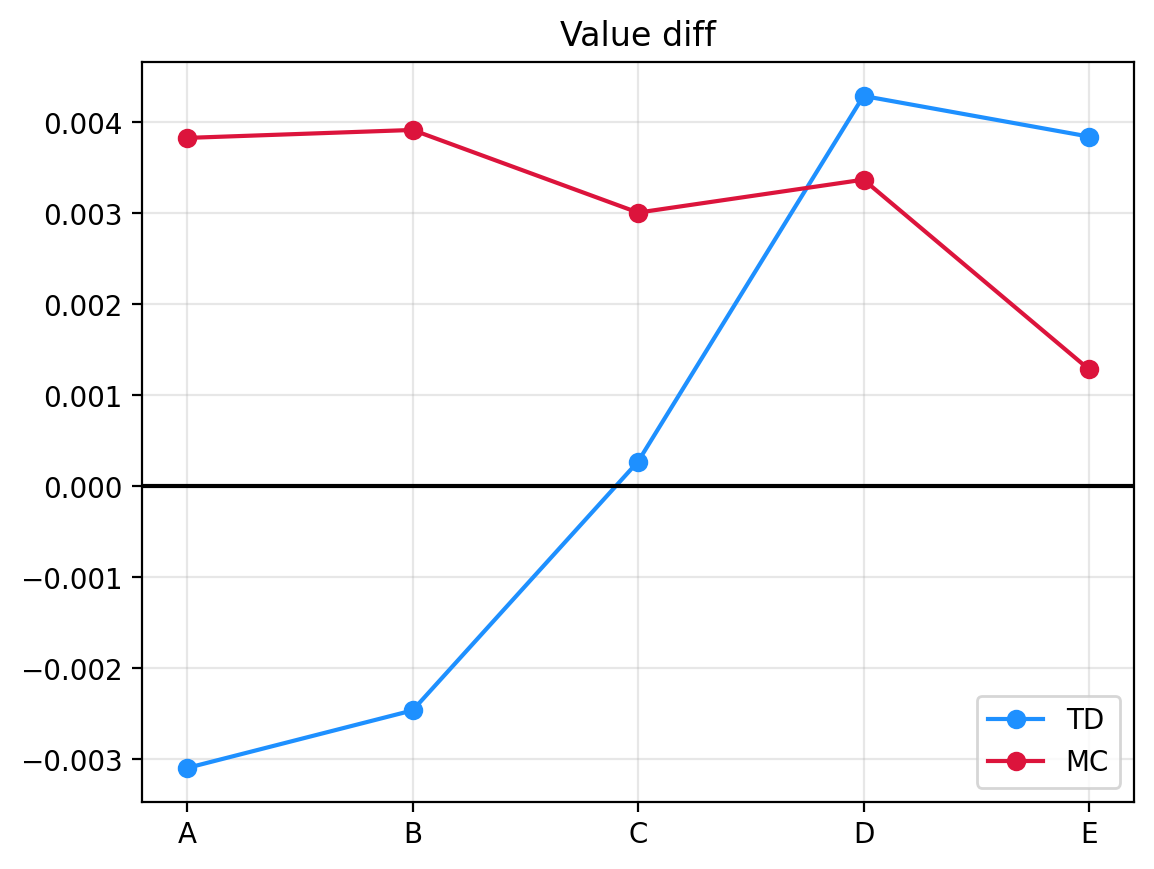

In [623]:
# plt.plot(states[1:], value_array, c="black", marker="o", label="True")
plt.plot(states[1:], value_array - values_td_final.mean(axis=0)[1:], marker="o", c="dodgerblue", label="TD")
plt.plot(states[1:], value_array - values_mc_final.mean(axis=0)[1:], marker="o", c="crimson", label="MC")
plt.axhline(y=0, c="black")
plt.legend()
plt.title("Value diff")
plt.xticks(states[1:], labels=labels)
plt.grid(alpha=0.3)

## Altenative formulation

In [226]:
@njit
def sample_run_full_multiple(state_init, n_runs):
    state_hist_full = []
    rewards_hist_full = []
    
    for n in range(n_runs):
        s_hist, r_hist = sample_run_full(state_init)
        state_hist_full.extend(s_hist)
        rewards_hist_full.extend(r_hist)
        rewards_hist_full.append(-1)
        
    state_hist_full = np.array(state_hist_full)
    rewards_hist_full = np.array(rewards_hist_full)
    return state_hist_full, rewards_hist_full


@njit
def batch_update_mc(value, sinit, alpha, gamma, state_hist, return_hist):
    # Every-visit (batch update) MC
    increments = np.zeros_like(value)

    rettot = 0.0
    increments = np.zeros_like(value)
    for state, ret in zip(state_hist[::-1], return_hist[::-1]):
        if ret == -1: # update and reset
            # update value after batch
            value = value + increments
            increments = np.zeros_like(value)
            # reset counts
            rettot = 0.0
            continue

        rettot += ret
        increments[state] += alpha * (rettot - value[state])
    return value